# Development

In [1]:
import os.path, sys
sys.path.append(os.path.join(os.path.expanduser('~'), 'Documents', 'My Programs', 'Python Library'))
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import therpy_working as tp
import time
import numba
import scipy.integrate
import scipy.special

In [55]:
import scipy.integrate
import scipy.special

def FermiFunctionExact_(m, z):
    func = lambda x: (z * np.exp(-x) * x**(m-1)) / (1 + z * np.exp(-x))
    return scipy.integrate.quad(func, 0, np.inf)[0] / scipy.special.gamma(m)

In [56]:
def FermiFunctionSmallZ_(m, z):
    '''
    Details about the expansion are in Mehran Kardar's notes at
    http://ocw.mit.edu/courses/physics/8-333-statistical-mechanics-i-statistical-mechanics-of-particles-fall-2013/lecture-notes/MIT8_333F13_Lec23.pdf
    '''
    return z - z**2/2**m + z**3/3**m - z**4/4**m + z**5/5**m - z**6/6**m


In [57]:
import scipy.misc
def FermiFunctionLargeZ_(m, logz):
    '''
    Details about the coefficients are in Mathematic file + Mehran Kardar's notes at
    http://ocw.mit.edu/courses/physics/8-333-statistical-mechanics-i-statistical-mechanics-of-particles-fall-2013/lecture-notes/MIT8_333F13_Lec24.pdf
    '''
    return logz**m / scipy.misc.factorial(m) * (1 +
        1.644934067 / logz ** 2 * m * (m - 1) +
        1.894065659 / logz ** 4 * m * (m - 1) * (m - 2) * (m - 3) +
        1.971102183 / logz ** 6 * m * (m - 1) * (m - 2) * (m - 3) * (m - 4) * (m - 5) +
        1.992466004 / logz ** 8 * m * (m - 1) * (m - 2) * (m - 3) * (m - 4) * (m - 5) * (m - 6) * (m - 7) +
        1.998079015 / logz ** 10 * m * (m - 1) * (m - 2) * (m - 3) * (m - 4) * (m - 5) * (m - 6) * (m - 7) * (m - 8) * (m - 9)
    )

In [3]:
def FermiFunction_Integrand_(x, m, z):
    return (z * np.exp(-x) * x**(m-1)) / (1 + z * np.exp(-x))
# Limits
ZSMALL = 0.1
LOGZLARGE = 10

@np.vectorize
def FermiFunction_Vectorize(m, logz):
    '''
    Inputs:
        m: order of fermi function. Pressure is 5/2, Density is 3/2, etc.
        logz: logz = betamu

    Returns:
        FermiFunction[m, z] = -PolyLog(m, -z)

    Notes for logz input:
        For high z (logz > 10):
            Sommerfeld expansion in log(z) is used with first 6 terms in the sum
        For low z (z < 0.1):
            Summation expansion is used with first 6 terms
        For other values of z:
            The integral is calculated numerically
            
        These approximation will result in error of at max 1 ppm for m = 1/2, 3/2, 5/2, 7/2.
        Speed improvements are at least 100x. 
        At the extreme values, the integral may become unstable, but the approximations are well defined. 
    '''
    # Large z limit
    if (logz > LOGZLARGE):
        return logz**m / scipy.misc.factorial(m) * (1 + 
               1.644934067 / logz ** 2 * m * (m - 1) + 
               1.894065659 / logz ** 4 * m * (m - 1) * (m - 2) * (m - 3) + 
               1.971102183 / logz ** 6 * m * (m - 1) * (m - 2) * (m - 3) * (m - 4) * (m - 5) + 
               1.992466004 / logz ** 8 * m * (m - 1) * (m - 2) * (m - 3) * (m - 4) * (m - 5) * (m - 6) * (m - 7) + 
               1.998079015 / logz ** 10 * m * (m - 1) * (m - 2) * (m - 3) * (m - 4) * (m - 5) * (m - 6) * (m - 7) * (m - 8) * (m - 9))
    # Small z limit
    z = np.exp(logz)
    if (z < ZSMALL):
        return z - z**2/2**m + z**3/3**m - z**4/4**m + z**5/5**m - z**6/6**m
    # Exact
    return scipy.integrate.quad(FermiFunction_Integrand_, 0, np.inf, args=(m, z,))[0] / scipy.special.gamma(m)


In [2]:
def FermiFunction_Manual(m, z=None, logz=None):
    '''
    Inputs:
        m: order of fermi function. Pressure is 5/2, Density is 3/2, etc.
        logz or z: logz is prefered, logz = betamu
    Returns:
        FermiFunction[m, z] = -PolyLog(m, -z)
    Notes for logz input:
        For high z (logz > 10):
            Sommerfeld expansion in log(z) is used with first 6 terms in the sum
        For low z (z < 0.1):
            Summation expansion is used with first 6 terms
        For other values of z:
            The integral is calculated numerically
            
        These approximation will result in error of at max 1 ppm for m = 1/2, 3/2, 5/2, 7/2.
        Speed improvements are at least 100x. 
        At the extreme values, the integral may become unstable, but the approximations are well defined. 
    '''
    # Limits Constnts
    ZSMALL = 0.1
    LOGZLARGE = 10
    # Process inputs --
    if logz is not None: z = np.exp(logz)
    elif z is not None: logz = np.log(z)
    else: raise RuntimeError("Please provide z or logz to FermiFunction(m, z or logz)")
    # process inputs -- make everything arrays
    args = [z, logz]
    for i in range(len(args)):
        if type(args[i]) is list: args[i] = np.array(args[i])
        elif type(args[i]) is int: args[i] = np.array([args[i]], np.float32)
        elif type(args[i]) is float: args[i] = np.array([args[i]])
        elif type(args[i]) == type(np.log(10)): args[i] = np.array([args[i]])
    z, logz = args[0], args[1]
    # Evaluate Fermi Integral
    res = np.zeros_like(z) * np.nan
    for i in range(res.size):
        # small z limit
        if z[i] < ZSMALL:
            res[i] = FermiFunctionSmallZ_(m, z[i])
        # Large z limit
        elif logz[i] > LOGZLARGE:
            res[i] = FermiFunctionLargeZ_(m, logz[i])
        # Exact integral
        else:
            res[i] = FermiFunctionExact_(m, z[i])
    # Return results
    if res.size == 1: return res[0]
    else: return res

# Tests

## Inputs : scalar and array 

In [4]:
FermiFunction_Vectorize(3/2,logz=np.array([20, 1, np.log(0.05)]))
FermiFunction_Vectorize(3/2,logz=[20, 1, np.log(0.05)])
FermiFunction_Vectorize(3/2,logz=np.linspace(0,1,5))
FermiFunction_Vectorize(3/2,logz=9)

NameError: name 'scipy' is not defined

In [120]:
FermiFunction_Manual(3/2,logz=np.array([20, 1, np.log(0.05)]))
FermiFunction_Manual(3/2,logz=[20, 1, np.log(0.05)])
FermiFunction_Manual(3/2,logz=np.linspace(0,1,5))
FermiFunction_Manual(3/2,logz=9)

20.624018211566423

## Speed : Vectorize vs Manual

In [100]:
m = 3/2
logz = 13.82
N = 5000

start = time.time()
for i in range(N): ff1 = FermiFunction_Vectorize(m,logz)
stop = time.time()
time_vect = stop - start

start = time.time()
for i in range(N): ff2 = FermiFunction_Manual(m,logz=logz)
stop = time.time()
time_man = stop - start

start = time.time()
for i in range(N): ff3 = FermiFunctionLargeZ_(m,logz)
stop = time.time()
time_dir = stop - start

print("vectorize  timing: {:.3f} s / 1000".format(time_vect/N*1e3))
print("Manual     timing: {:.3f} s / 1000".format(time_man/N*1e3))
print("Direct     timing: {:.3f} s / 1000".format(time_dir/N*1e3))
print("Vectorize of {:.3f} x".format(time_vect/time_dir))
print("Manual of {:.3f} x".format(time_man/time_dir))
print("Vect: {} vs Man: {} vs Direct: {}".format(ff1, ff2, ff3))

vectorize  timing: 0.074 s / 1000
Manual     timing: 0.034 s / 1000
Direct     timing: 0.013 s / 1000
Vectorize of 5.627 x
Manual of 2.573 x
Vect: 38.898731340265535 vs Man: 38.898731340265535 vs Direct: 38.898731340265535


In [115]:
m = 3/2
z = 0.05
logz = np.log(z)
N = 5000

start = time.time()
for i in range(N): ff1 = FermiFunction_Vectorize(m,logz)
stop = time.time()
time_vect = stop - start

start = time.time()
for i in range(N): ff2 = FermiFunction_Manual(m,logz=logz)
stop = time.time()
time_man = stop - start

start = time.time()
for i in range(N): ff3 = FermiFunctionSmallZ_(m,z)
stop = time.time()
time_dir = stop - start

print("vectorize  timing: {:.3f} s / 1000".format(time_vect/N*1e3))
print("Manual     timing: {:.3f} s / 1000".format(time_man/N*1e3))
print("Direct     timing: {:.3f} s / 1000".format(time_dir/N*1e3))
print("Vectorize of {:.3f} x".format(time_vect/time_dir))
print("Manual of {:.3f} x".format(time_man/time_dir))
print("Vect: {} vs Man: {} vs Direct: {}".format(ff1, ff2, ff3))

vectorize  timing: 0.042 s / 1000
Manual     timing: 0.024 s / 1000
Direct     timing: 0.002 s / 1000
Vectorize of 27.178 x
Manual of 15.619 x
Vect: 0.049139418422436194 vs Man: 0.049139418422436194 vs Direct: 0.04913941842243619


In [116]:
m = 3/2
z = 100
logz = np.log(z)
N = 1000

start = time.time()
for i in range(N): ff1 = FermiFunction_Vectorize(m,logz)
stop = time.time()
time_vect = stop - start

start = time.time()
for i in range(N): ff2 = FermiFunction_Manual(m,logz=logz)
stop = time.time()
time_man = stop - start

start = time.time()
for i in range(N): ff3 = FermiFunctionExact_(m,z)
stop = time.time()
time_dir = stop - start

print("vectorize  timing: {:.3f} s / 1000".format(time_vect/N*1e3))
print("Manual     timing: {:.3f} s / 1000".format(time_man/N*1e3))
print("Direct     timing: {:.3f} s / 1000".format(time_dir/N*1e3))
print("Vectorize of {:.3f} x".format(time_vect/time_dir))
print("Manual of {:.3f} x".format(time_man/time_dir))
print("Vect: {} vs Man: {} vs Direct: {}".format(ff1, ff2, ff3))

vectorize  timing: 2.312 s / 1000
Manual     timing: 1.450 s / 1000
Direct     timing: 1.847 s / 1000
Vectorize of 1.252 x
Manual of 0.785 x
Vect: 7.88910191472153 vs Man: 7.88910191472153 vs Direct: 7.889101914721532


## High Z Limit Timing

In [4]:
m = 3/2
logz = 13.82
z = np.exp(logz)
N = 1000

start = time.time()
for i in range(N): ff1 = tp.functions.FermiFunctionExact_(m,z)
stop = time.time()
time_exact = stop - start

start = time.time()
for i in range(N): ff2 = tp.functions.FermiFunctionLargeZ_(m,logz)
stop = time.time()
time_approx = stop - start

print("Exact  timing: {:.3f} s / 1000".format(time_exact/N*1e3))
print("Approx timing: {:.3f} s / 1000".format(time_approx/N*1e3))
print("Improvement of {:.3f} x".format(time_exact/time_approx))
print("Exact: {:.6f} vs Appx: {:.6f}".format(ff1, ff2))

Exact  timing: 1.650 s / 1000
Approx timing: 0.015 s / 1000
Improvement of 112.879 x
Exact: 38.898733 vs Appx: 38.898731


## Low Z Limit Timing

In [5]:
m = 3/2
z = 0.05
logz = np.log(z)
N = 10000

start = time.time()
for i in range(N): ff1 = tp.functions.FermiFunctionExact_(m,z)
stop = time.time()
time_exact = stop - start

start = time.time()
for i in range(N): ff2 = tp.functions.FermiFunctionSmallZ_(m,z)
stop = time.time()
time_approx = stop - start

print("Exact  timing: {:.3f} s / 1000".format(time_exact/N*1e3))
print("Approx timing: {:.3f} s / 1000".format(time_approx/N*1e3))
print("Improvement of {:.3f} x".format(time_exact/time_approx))
print("Exact: {:.6f} vs Appx: {:.6f}".format(ff1, ff2))

Exact  timing: 1.035 s / 1000
Approx timing: 0.002 s / 1000
Improvement of 557.696 x
Exact: 0.049139 vs Appx: 0.049139


## High Z Accuracy

[<matplotlib.text.Text at 0x11a1e10f0>, <matplotlib.text.Text at 0x11a2041d0>]

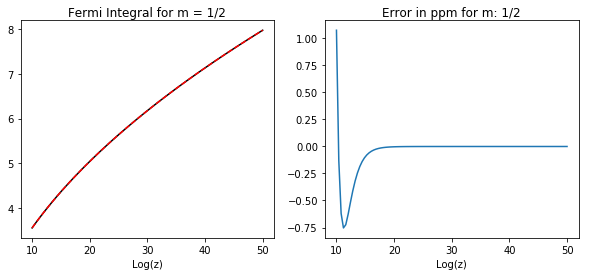

In [14]:
## For m = 1/2
m = 1/2
logz = np.linspace(10,50,100)
z = np.exp(logz)
ff1 = np.zeros_like(z)
ff2 = np.zeros_like(z)

for i in range(z.size):
    ff1[i] = tp.functions.FermiFunctionExact_(m,z[i])
    ff2[i] = tp.functions.FermiFunctionLargeZ_(m,logz[i])

error = (ff1 - ff2)/ff1 * 1e6

fig,ax = plt.subplots(ncols=2,figsize=(10,4))
ax[0].plot(logz, ff1, 'k-')
ax[0].plot(logz, ff2, 'r--')
ax[0].set(title='Fermi Integral for m = 1/2', xlabel='Log(z)')
ax[1].plot(logz, error)
ax[1].set(title="Error in ppm for m: 1/2", xlabel='Log(z)')

[<matplotlib.text.Text at 0x11a2a9a20>, <matplotlib.text.Text at 0x11a4a7b00>]

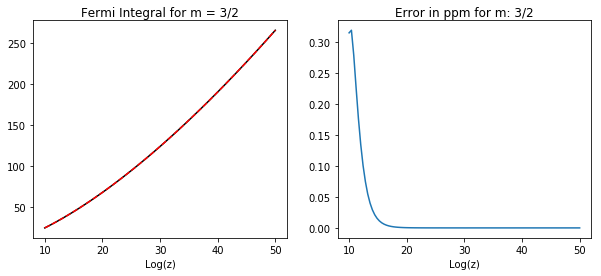

In [15]:
## For m = 3/2
m = 3/2
logz = np.linspace(10,50,100)
z = np.exp(logz)
ff1 = np.zeros_like(z)
ff2 = np.zeros_like(z)

for i in range(z.size):
    ff1[i] = tp.functions.FermiFunctionExact_(m,z[i])
    ff2[i] = tp.functions.FermiFunctionLargeZ_(m,logz[i])

error = (ff1 - ff2)/ff1 * 1e6

fig,ax = plt.subplots(ncols=2,figsize=(10,4))
ax[0].plot(logz, ff1, 'k-')
ax[0].plot(logz, ff2, 'r--')
ax[0].set(title='Fermi Integral for m = 3/2', xlabel='Log(z)')
ax[1].plot(logz, error)
ax[1].set(title="Error in ppm for m: 3/2", xlabel='Log(z)')

[<matplotlib.text.Text at 0x11a5d0048>, <matplotlib.text.Text at 0x11a5f7240>]

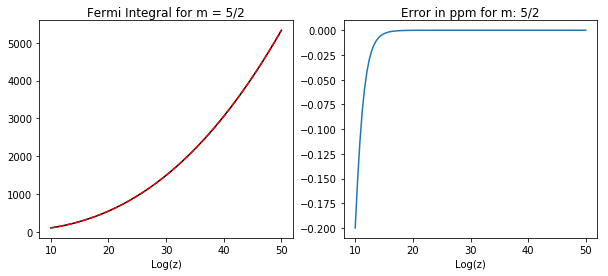

In [16]:
## For m = 5/2
m = 5/2
logz = np.linspace(10,50,100)
z = np.exp(logz)
ff1 = np.zeros_like(z)
ff2 = np.zeros_like(z)

for i in range(z.size):
    ff1[i] = tp.functions.FermiFunctionExact_(m,z[i])
    ff2[i] = tp.functions.FermiFunctionLargeZ_(m,logz[i])

error = (ff1 - ff2)/ff1 * 1e6

fig,ax = plt.subplots(ncols=2,figsize=(10,4))
ax[0].plot(logz, ff1, 'k-')
ax[0].plot(logz, ff2, 'r--')
ax[0].set(title='Fermi Integral for m = 5/2', xlabel='Log(z)')
ax[1].plot(logz, error)
ax[1].set(title="Error in ppm for m: 5/2", xlabel='Log(z)')

[<matplotlib.text.Text at 0x11a749c18>, <matplotlib.text.Text at 0x11a770cf8>]

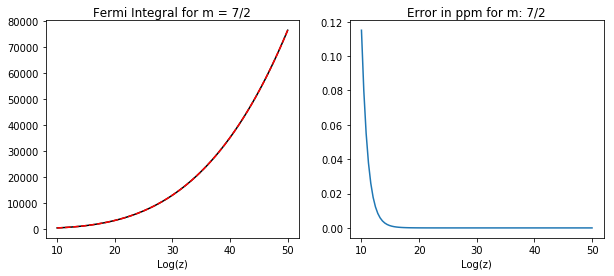

In [17]:
## For m = 7/2
m = 7/2
logz = np.linspace(10,50,100)
z = np.exp(logz)
ff1 = np.zeros_like(z)
ff2 = np.zeros_like(z)

for i in range(z.size):
    ff1[i] = tp.functions.FermiFunctionExact_(m,z[i])
    ff2[i] = tp.functions.FermiFunctionLargeZ_(m,logz[i])

error = (ff1 - ff2)/ff1 * 1e6

fig,ax = plt.subplots(ncols=2,figsize=(10,4))
ax[0].plot(logz, ff1, 'k-')
ax[0].plot(logz, ff2, 'r--')
ax[0].set(title='Fermi Integral for m = 7/2', xlabel='Log(z)')
ax[1].plot(logz, error)
ax[1].set(title="Error in ppm for m: 7/2", xlabel='Log(z)')

## Low Z Accuracy

/Users/RanchoP/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


[<matplotlib.text.Text at 0x11a9de208>, <matplotlib.text.Text at 0x11a9fe4a8>]

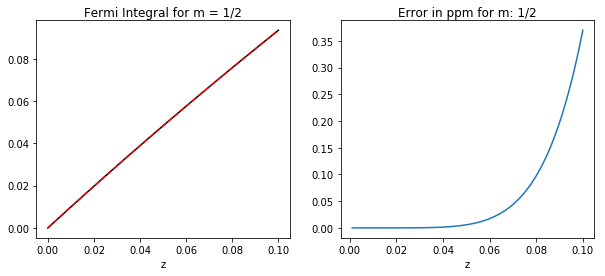

In [18]:
## For m = 1/2
m = 1/2
z = np.linspace(0,0.1,100)
ff1 = np.zeros_like(z)
ff2 = np.zeros_like(z)

for i in range(z.size):
    ff1[i] = tp.functions.FermiFunctionExact_(m,z[i])
    ff2[i] = tp.functions.FermiFunctionSmallZ_(m,z[i])

error = (ff1 - ff2)/ff1 * 1e6

fig,ax = plt.subplots(ncols=2,figsize=(10,4))
ax[0].plot(z, ff1, 'k-')
ax[0].plot(z, ff2, 'r--')
ax[0].set(title='Fermi Integral for m = 1/2', xlabel='z')
ax[1].plot(z, error)
ax[1].set(title="Error in ppm for m: 1/2", xlabel='z')

/Users/RanchoP/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


[<matplotlib.text.Text at 0x11ab4ea90>, <matplotlib.text.Text at 0x11ab58780>]

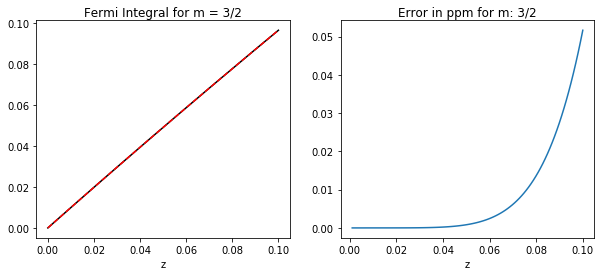

In [19]:
## For m = 3/2
m = 3/2
z = np.linspace(0,0.1,100)
ff1 = np.zeros_like(z)
ff2 = np.zeros_like(z)

for i in range(z.size):
    ff1[i] = tp.functions.FermiFunctionExact_(m,z[i])
    ff2[i] = tp.functions.FermiFunctionSmallZ_(m,z[i])

error = (ff1 - ff2)/ff1 * 1e6

fig,ax = plt.subplots(ncols=2,figsize=(10,4))
ax[0].plot(z, ff1, 'k-')
ax[0].plot(z, ff2, 'r--')
ax[0].set(title='Fermi Integral for m = 3/2', xlabel='z')
ax[1].plot(z, error)
ax[1].set(title="Error in ppm for m: 3/2", xlabel='z')

/Users/RanchoP/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


[<matplotlib.text.Text at 0x11acc8828>, <matplotlib.text.Text at 0x11aced908>]

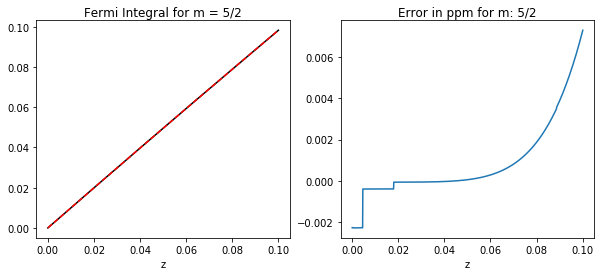

In [20]:
## For m = 5/2
m = 5/2
z = np.linspace(0,0.1,1000)
ff1 = np.zeros_like(z)
ff2 = np.zeros_like(z)

for i in range(z.size):
    ff1[i] = tp.functions.FermiFunctionExact_(m,z[i])
    ff2[i] = tp.functions.FermiFunctionSmallZ_(m,z[i])

error = (ff1 - ff2)/ff1 * 1e6

fig,ax = plt.subplots(ncols=2,figsize=(10,4))
ax[0].plot(z, ff1, 'k-')
ax[0].plot(z, ff2, 'r--')
ax[0].set(title='Fermi Integral for m = 5/2', xlabel='z')
ax[1].plot(z, error)
ax[1].set(title="Error in ppm for m: 5/2", xlabel='z')

/Users/RanchoP/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


[<matplotlib.text.Text at 0x11af4d320>, <matplotlib.text.Text at 0x11af71518>]

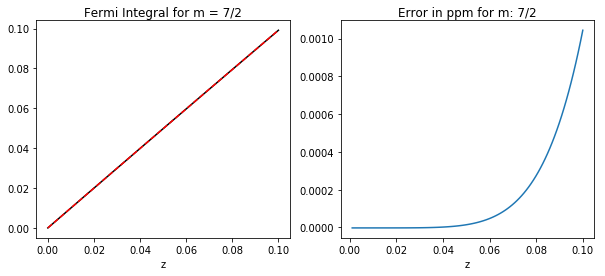

In [21]:
## For m = 7/2
m = 7/2
z = np.linspace(0,0.1,100)
ff1 = np.zeros_like(z)
ff2 = np.zeros_like(z)

for i in range(z.size):
    ff1[i] = tp.functions.FermiFunctionExact_(m,z[i])
    ff2[i] = tp.functions.FermiFunctionSmallZ_(m,z[i])

error = (ff1 - ff2)/ff1 * 1e6

fig,ax = plt.subplots(ncols=2,figsize=(10,4))
ax[0].plot(z, ff1, 'k-')
ax[0].plot(z, ff2, 'r--')
ax[0].set(title='Fermi Integral for m = 7/2', xlabel='z')
ax[1].plot(z, error)
ax[1].set(title="Error in ppm for m: 7/2", xlabel='z')